In [5]:
%pip install tensorflow

import numpy as np
import h5py
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D, BatchNormalization, Activation, AveragePooling2D, Dropout, Flatten, Dense, Embedding, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess data
X_all = []
y_all = []
subject_ids = []

ch_ch = list(range(63))
g_ch = list(range(61))
ch_rem = [0, 2, 6, 8, 29, 31, 51, 55]
g_rem = [46, 49, 56, 58, 59, 60]

for i in ch_rem:
    ch_ch.remove(i)
for j in g_rem:
    g_ch.remove(j)

# Load Chinese dataset (Subjects 0-4)
for subj in range(1, 10):
    file_path = fr'C:\Users\USER\Desktop\RA\data_ch\ASK\sbj_{subj}.mat'
    try:
        mat_data = loadmat(file_path)
        X = np.array(mat_data['x_post'])[:-1, ch_ch, :]
        y = np.array(mat_data['label_next_ind'])[0, :]
        X = np.transpose(X)
        X_all.append(X)
        y_all.append(y)
        subject_ids.extend([subj - 1] * X.shape[0])
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")

# Load Korean dataset (Subjects 5-11)
for subj in range(1, 15):
    file_path = fr'C:\Users\USER\Desktop\RA\data\ASK\sbj_{subj}.mat'
    try:
        with h5py.File(file_path, 'r') as f:
            X = np.array(f['x_post'])[:, g_ch, :]
            y = np.array(f['label_next_ind'])[:, 0]
            X_all.append(X)
            y_all.append(y)
            subject_ids.extend([subj + 3] * X.shape[0])
    except OSError as e:
        print(f"Error loading file {file_path}: {e}")

# Convert lists to numpy arrays
data = np.concatenate(X_all, axis=0)
labels = np.concatenate(y_all, axis=0)
subject_ids = np.array(subject_ids)

# Normalize data
data_flattened = data.reshape(data.shape[0], -1)
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_flattened).reshape(data.shape)

# Balance classes per subject
balanced_data = []
balanced_labels = []
balanced_subjects = []

for subj in np.unique(subject_ids):
    subj_mask = subject_ids == subj
    X_subj, y_subj = data_normalized[subj_mask], labels[subj_mask]
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_res, y_res = rus.fit_resample(X_subj.reshape(X_subj.shape[0], -1), y_subj)
    balanced_data.append(X_res.reshape(X_res.shape[0], *data.shape[1:]))
    balanced_labels.append(y_res)
    balanced_subjects.append(np.full(y_res.shape, subj))

data_balanced = np.concatenate(balanced_data)
labels_balanced = np.concatenate(balanced_labels)
subject_ids_balanced = np.concatenate(balanced_subjects)
subject_ids_balanced = np.clip(subject_ids_balanced, 0, 11)

# Train/Test Split (Stratified by Subject)
X_train, X_temp, y_train, y_temp, subj_train, subj_temp = train_test_split(
    data_balanced, labels_balanced, subject_ids_balanced, test_size=0.2, random_state=42, stratify=subject_ids_balanced
)
X_val, X_test, y_val, y_test, subj_val, subj_test = train_test_split(
    X_temp, y_temp, subj_temp, test_size=0.5, random_state=42, stratify=subj_temp
)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Define EEGNet model
def EEGNet_with_subject(nb_classes=2, Chans=55, Samples=100, nb_subjects=12, dropoutRate=0.5):
    eeg_input = Input(shape=(Chans, Samples, 1), name="EEG_Input")
    subject_input = Input(shape=(1,), dtype='int32', name="Subject_Input")
    subject_embedding = Embedding(input_dim=nb_subjects, output_dim=8)(subject_input)
    subject_embedding = Flatten()(subject_embedding)
    x = Conv2D(16, (1, 10), padding='same', use_bias=False)(eeg_input)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=2, depthwise_constraint=tf.keras.constraints.max_norm(1.))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropoutRate)(x)
    x = SeparableConv2D(16, (1, 10), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropoutRate)(x)
    x = Flatten()(x)
    x = Concatenate()([x, subject_embedding])
    x = Dense(nb_classes, activation='sigmoid')(x)
    return Model(inputs=[eeg_input, subject_input], outputs=x)

model = EEGNet_with_subject(nb_classes=2, nb_subjects=12)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train model



Note: you may need to restart the kernel to use updated packages.


In [6]:
X_train = [X_train, np.expand_dims(subj_train, axis=-1)]
X_val = [X_val, np.expand_dims(subj_val, axis=-1)]

Epoch 1/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5003 - loss: 0.7141 - val_accuracy: 0.5033 - val_loss: 0.6925
Epoch 2/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5077 - loss: 0.6961 - val_accuracy: 0.5051 - val_loss: 0.6920
Epoch 3/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5108 - loss: 0.6929 - val_accuracy: 0.5026 - val_loss: 0.6905
Epoch 4/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5120 - loss: 0.6925 - val_accuracy: 0.5033 - val_loss: 0.6896
Epoch 5/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5151 - loss: 0.6916 - val_accuracy: 0.4992 - val_loss: 0.6909
Epoch 6/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5194 - loss: 0.6910 - val_accuracy: 0.5120 - val_loss: 0.6902
Epoch 7/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5181 - loss: 0.6906 - val_accuracy: 0.5151 - val_loss: 0.6886
Epoch 8/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5238 - loss: 0.6900 - val_accuracy: 0.

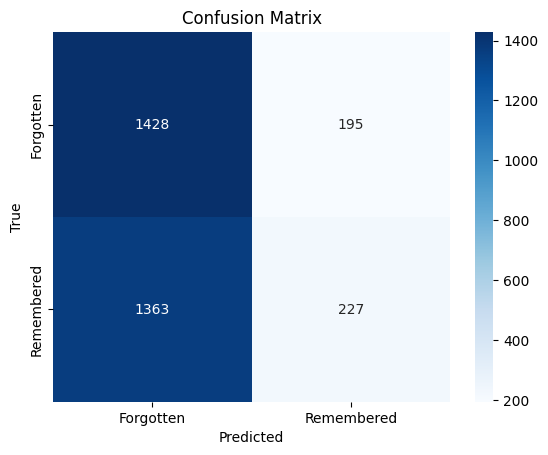

              precision    recall  f1-score   support

           0       0.51      0.88      0.65      1623
           1       0.54      0.14      0.23      1590

    accuracy                           0.52      3213
   macro avg       0.52      0.51      0.44      3213
weighted avg       0.52      0.52      0.44      3213



In [7]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_val, y_val))

# Evaluate model
y_pred = model.predict([X_test, np.expand_dims(subj_test, axis=-1)])
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Forgotten', 'Remembered'], yticklabels=['Forgotten', 'Remembered'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_true_labels, y_pred_labels))

In [8]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(accuracy)

0.5150949268596328
